# Map features from other channels/images

Import packages

In [48]:
from skimage import io, data, morphology, filters, measure
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import colorcet as cc
from matplotlib import colors

## Example data

In [190]:
image = data.hubble_deep_field()[:500, :500]
image = np.rollaxis(image, 2)
image_list = [image[i] for i in range(2)]

In [191]:
disk = morphology.disk(30)
image_list[0] = morphology.dilation(image_list[0], disk)
# image[...,0] = morphology.dilation(image[...,0], disk)

In [192]:
# Convert from hexadecimal to rgb (list of tuples) and add first color as black
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16)  / 255 for i in range(0, lv, lv // 3))
glasbey_rgb = [hex_to_rgb(color)  for color in cc.glasbey]
glasbey_rgb.insert(0, (0., 0., 0.))

In [193]:
# Create colormap object for matplotlib
glasbey_cm = colors.LinearSegmentedColormap.from_list('glasbey', glasbey_rgb)

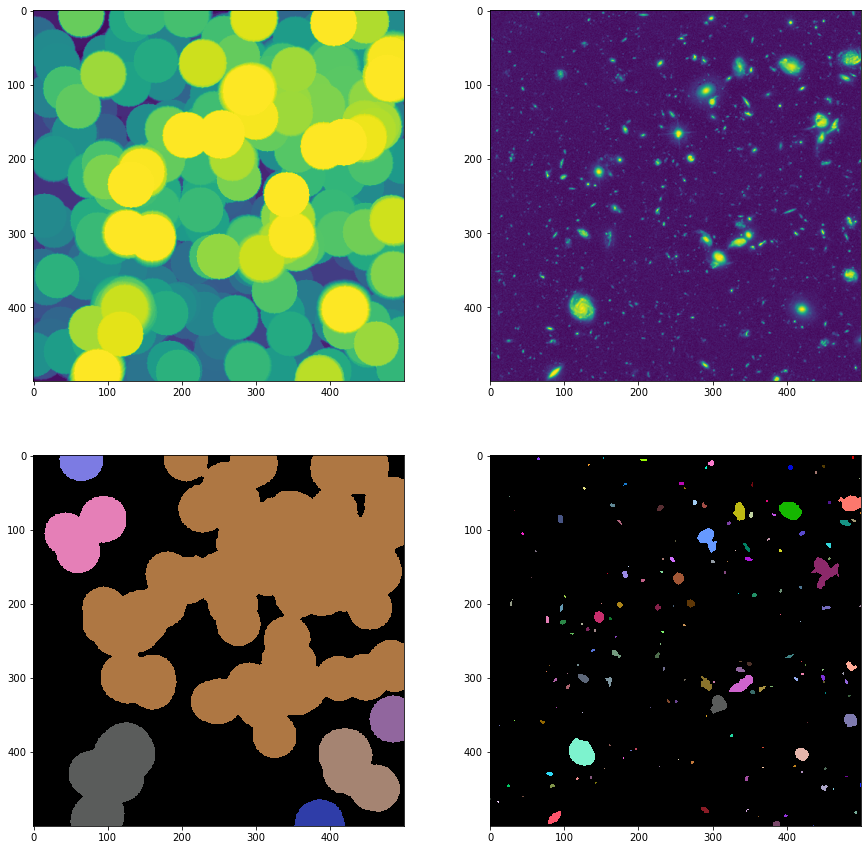

In [194]:
fig, ax = plt.subplots(2,2, figsize=(15,15))
labels_list = []
for i, image in enumerate(image_list):
    ax[0,i].imshow(image)
    image_gauss = filters.gaussian(image)
    th = filters.threshold_otsu(image_gauss)
    image_bin = image_gauss > th
    image_bin = morphology.binary_closing(image_bin, morphology.disk(2))
    image_bin = morphology.remove_small_holes(image_bin)
    label_image = measure.label(image_bin)
    ax[1,i].imshow(label_image, cmap=glasbey_cm, interpolation='none')
    labels_list += [label_image]

## Goal

Measure properties of objects inside objects from another image/channel

## Measure properties

Measure properties of channel2 (small elements) and links labels of channel2 to labels of channel1 (big elements)

In [200]:
def mode(regionmask, intensity_image):
    '''Returns the most frequent element.'''
    import numpy as np
    return np.bincount(np.ravel(intensity_image[regionmask].astype(int))).argmax()

In [201]:
label_links= pd.DataFrame(
    measure.regionprops_table(label_image = labels_list[1], 
                              intensity_image = labels_list[0], 
                              properties = ['label',],
                              extra_properties = [mode]
                             )
).astype(int)
# rename column
label_links.rename(columns={'label':'channel2_label', 'mode':'channel1_corresponding_label'}, inplace=True)
label_links

,channel2_label,channel1_corresponding_label
0,1,0
1,2,1
2,3,0
3,4,2
4,5,2
...,...,...
179,180,0
180,181,7
181,182,7
182,183,7


In [202]:
channel1_props =  measure.regionprops_table(label_image = labels_list[0],
                              intensity_image = image_list[0],
                              properties = ['label', 'intensity_mean']
                                            )

Make a dictionary to convert from channel1 label number to channel1 intensity

In [203]:
channel1_intensity_dict = dict([[a, b] for a, b in zip(channel1_props['label'].tolist(), channel1_props['intensity_mean'].tolist())])

In [204]:
channel1_intensity_dict

{1: 202.9959420289855,
 2: 229.0467840817162,
 3: 206.28634482758622,
 4: 211.33843674456085,
 5: 235.8674131342753,
 6: 229.99175963488844,
 7: 228.41692627206646}

Duplicate nucleus label column and replace name by 'nuclei_intensity' and replace labels by intensities

In [205]:
label_links['channel1_intensity_mean'] = label_links['channel1_corresponding_label']
label_links = label_links.replace({'channel1_intensity_mean' : channel1_intensity_dict})
label_links

,channel2_label,channel1_corresponding_label,channel1_intensity_mean
0,1,0,0.000000
1,2,1,202.995942
2,3,0,0.000000
3,4,2,229.046784
4,5,2,229.046784
...,...,...,...
179,180,0,0.000000
180,181,7,228.416926
181,182,7,228.416926
182,183,7,228.416926


In [206]:
channel2_props = pd.DataFrame(
    measure.regionprops_table(label_image = labels_list[1], 
                              intensity_image = image_list[1], 
                              properties = ['intensity_mean', 'area']
                             )
)
# rename column
channel2_props.rename(columns={'intensity_mean':'channel2_intensity_mean', 'area':'channel2_area'}, inplace=True)

In [207]:
pd.concat([label_links, channel2_props], axis=1)

,channel2_label,channel1_corresponding_label,channel1_intensity_mean,channel2_intensity_mean,channel2_area
0,1,0,0.000000,125.300000,10
1,2,1,202.995942,142.500000,10
2,3,0,0.000000,177.500000,2
3,4,2,229.046784,144.692308,26
4,5,2,229.046784,160.591837,49
...,...,...,...,...,...
179,180,0,0.000000,148.181818,11
180,181,7,228.416926,139.882353,17
181,182,7,228.416926,162.000000,2
182,183,7,228.416926,175.035088,57
